# Additional Charts for Illinois Tab

### Fan Wang
### 03/19/2021

This Jupyter notebook shows some examples of charts to be added to the IL dashboard in [Chicagoland COVID-19 Data Commons](https://chicagoland.pandemicresponsecommons.org). Please find the related Jira ticket [here](https://occ-data.atlassian.net/browse/COV-796).
## Table of Contents

* [Install and Import Required Library](#Install-and-Import-Required-Library)
* [Age/Race/Gender Demographics in Illinois ](#Age/Race/Gender-Demographics-in-Illinois)
    * [Age Demographics](#Age-Demographics)
    * [Race Demographics](#Race-Demographics)
    * [Gender Demographics](#Gender-Demographics)
* [Total and Daily Administered Vaccine Doses](#Total-and-Daily-Administered-Vaccine-Doses)
    * [Daily Reported Administered Vaccine Doses in Illinois](#Daily-Reported-Administered-Vaccine-Doses-in-Illinois)
    * [Cumulative Reported Administered Vaccine Doses in Illinois](#Cumulative-Reported-Administered-Vaccine-Doses-in-Illinois)
    * [Counties With The Highest Administered Vaccine Doses As Of The Most Recent Date](#Counties-With-The-Highest-Administered-Vaccine-Doses-As-Of-The-Most-Recent-Date)
    * [Counties With The Lowest Administered Vaccine Doses As Of The Most Recent Date](#Counties-With-The-Lowest-Administered-Vaccine-Doses-As-Of-The-Most-Recent-Date)
* [Google Mobility Data Visualization in Illinois](#Google-Mobility-Data-Visualization-in-Illinois)
* [Statistical Model Forecasts Cumulative COVID-19 Cases](#Statistical-Model-Forecasts-Cumulative-COVID-19-Cases)
    * [Using 4-Phase Sine-Logistic Model and Data from Past 180 Days to Obtain Cumulative Cases Forecasts for Future 10 Days](#Using-4-Phase-Sine-Logistic-Model-and-Data-from-Past-180-Days-to-Obtain-Cumulative-Cases-Forecasts-for-Future-10-Days)
    * [Using 4-Phase Sine-Logistic Model and Data from Past 360 Days to Obtain Cumulative Cases Forecasts for Future 30 Days](#Using-4-Phase-Sine-Logistic-Model-and-Data-from-Past-360-Days-to-Obtain-Cumulative-Cases-Forecasts-for-Future-30-Days)
    * [Using 4-phase Logistic Model and Data from Past 180 Days to Obtain Cumulative Cases Forecasts for Future 10 Days](#Using-4-phase-Logistic-Model-and-Data-from-Past-180-Days-to-Obtain-Cumulative-Cases-Forecasts-for-Future-10-Days)
    * [Using 4-phase Logistic Model and Data from Past 360 Days to Obtain Cumulative Cases Forecasts for Future 30 Days](#Using-4-phase-Logistic-Model-and-Data-from-Past-360-Days-to-Obtain-Cumulative-Cases-Forecasts-for-Future-30-Days)
    * [Using 4-Phase Logistic Model and Data from Past 360 Days to Obtain Daily New Cases Forecasts for Future 30 Days](#Using-4-Phase-Logistic-Model-and-Data-from-Past-360-Days-to-Obtain-Daily-New-Cases-Forecasts-for-Future-30-Days)

## Install and Import Required Library

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats # scientific python statistical package
from scipy.optimize import curve_fit # optimization for fitting curves
import urllib.request, json, os 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import warnings; warnings.filterwarnings("ignore")
import itertools
from itertools import islice
from collections import deque
#!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'
#!pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

## Age/Race/Gender Demographics in Illinois 
* Data source: [IDPH](https://www.dph.illinois.gov/covid19/covid19-statistics)
* API: https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetCountyDemographics

In [2]:
demographics_url = "https://idph.illinois.gov/DPHPublicInformation/api/COVID/GetCountyDemographics"
with urllib.request.urlopen(demographics_url) as url:
    data = json.loads(url.read().decode())
df = pd.json_normalize(data['county_demographics'])
age = pd.DataFrame(df.loc[df['County']=='Illinois']['demographics.age'].tolist()[0])

In [3]:
age_list=[]
for i in range(len(age)):
    single_age = pd.json_normalize(age['race'][i])
    single_age1 = single_age[['description','count']]
    single_age2=single_age1.set_index('description').T
    age_list.append(single_age2)
age_race = pd.concat(age_list)
age_race = age_race.reset_index(drop=True)
age_groupby_race = pd.concat([age, age_race], axis=1)
age_groupby_race = age_groupby_race.rename(columns={"Left Blank": "Unknown"})

In [4]:
date = pd.json_normalize(data['lastUpdatedDate'])
year = str(date.year.values[0])
month = str(date.month.values[0])
day = str(date.day.values[0])

### Age Demographics

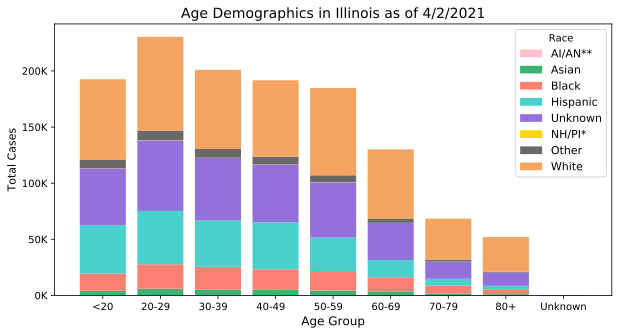

In [5]:
fig, ax = plt.subplots(figsize=(10,5), dpi= 100)
colors = ['pink', 'mediumseagreen','salmon','mediumturquoise','mediumpurple','gold','dimgray','sandybrown']
bottom = np.zeros(len(age_groupby_race))

for i, col in enumerate(age_groupby_race.columns[5:]):
    ax.bar(age_groupby_race.age_group, age_groupby_race[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(age_groupby_race[col])

ax.set_title('Age Demographics in Illinois as of {}/{}/{}'.format(month, day, year), size=14)
ax.set_xlabel('Age Group',size=12)
ax.set_ylabel('Total Cases',size=11)
ax.legend(fontsize=11, title="Race")

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatter = FuncFormatter(thousands)
ax.yaxis.set_major_formatter(formatter)
fig.savefig('IL_tab_charts_age_demographic.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

In [6]:
race = pd.DataFrame(df.loc[df['County']=='Illinois']['demographics.race'].tolist()[0])
race['color']=colors
race = race.replace('Left Blank', 'Unknown')

### Race Demographics

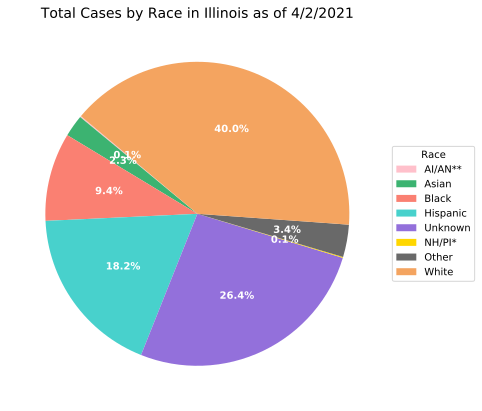

In [7]:
fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = race['count']
categories = race['description']
explode = [0]*8

def func(pct, allvals):
    return "{:.1f}%".format(pct)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=race['color'],
                                 startangle=140,
                                 explode=explode)

# Decoration
ax.legend(wedges, categories, title="Race", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title('Total Cases by Race in Illinois as of {}/{}/{}'.format(month, day, year),  size=14)
fig.savefig('IL_tab_charts_race_demographic.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Gender Demographics

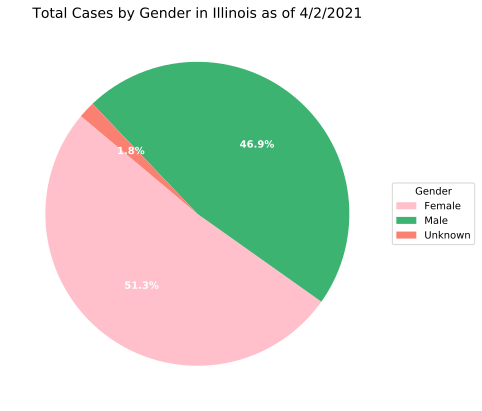

In [8]:
gender = pd.DataFrame(df.loc[df['County']=='Illinois']['demographics.gender'].tolist()[0])
gender = gender.replace('Unknown/Left Blank', 'Unknown')
fig, ax = plt.subplots(figsize=(8, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = gender['count']
categories = gender['description']
explode = [0]*3

def func(pct, allvals):
    return "{:.1f}%".format(pct)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=race['color'],
                                 startangle=140,
                                 explode=explode)

# Decoration
ax.legend(wedges, categories, title="Gender", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title('Total Cases by Gender in Illinois as of {}/{}/{}'.format(month, day, year),  size=14)
fig.savefig('IL_tab_charts_gender_demographic.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

## Total and Daily Administered Vaccine Doses
* Data Source: [IDPH COVID-19 Vaccine Administration Data](https://www.dph.illinois.gov/covid19/vaccinedata?county=Illinois) 
* API: https://idph.illinois.gov/DPHPublicInformation/api/COVIDExport/GetVaccineAdministration?countyname=&format=csv

In [9]:
vac = pd.read_csv('https://idph.illinois.gov/DPHPublicInformation/api/COVIDExport/GetVaccineAdministration?countyname=&format=csv', skiprows=1)

In [10]:
#Convert Report_Date column to datetimes format
s = "-"
datetime_index = pd.DatetimeIndex(vac.Report_Date)
vac.set_index(datetime_index, inplace=True)

In [11]:
# Function to calculate 7 days moving average
def seven_moving_average(data):
    it = iter(data)
    d = deque(islice(it, 7))
    divisor = float(7)
    s = sum(d)
    yield s / divisor
    for elem in it:
        s += elem - d.popleft()
        d.append(elem)
        yield s / divisor

In [12]:
moving_avg = list(seven_moving_average(list(vac['AdministeredCountChange'])))
average_table = vac[3:-3].copy()
average_table['7-Day Moving Avg'] = moving_avg

date = str(vac.index[-1])
year = date.split('-')[0]
month = date.split('-')[1]
day = date.split('-')[2].split(' ')[0]

### Daily Reported Administered Vaccine Doses in Illinois

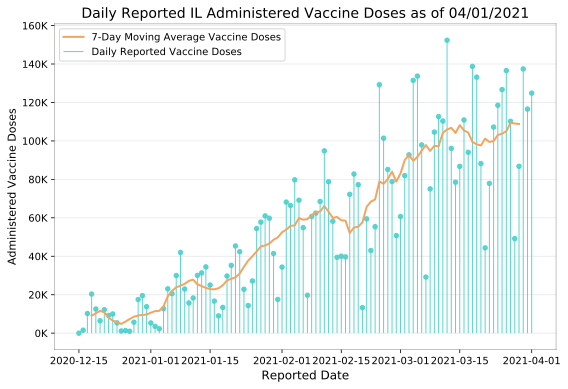

In [13]:
fig, ax = plt.subplots(figsize=(9,6), dpi= 100)
ax.vlines(x=vac.index, ymin=0, ymax=vac['AdministeredCountChange'], color='mediumturquoise', alpha=0.9, linewidth=1, label='Daily Reported Vaccine Doses')
ax.scatter(x=vac.index, y=vac['AdministeredCountChange'], s=20, color='mediumturquoise', alpha=0.9)
plt.plot(average_table.index, average_table['7-Day Moving Avg'].values, lw=2, color='sandybrown', label='7-Day Moving Average Vaccine Doses') 
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)
plt.legend(loc='upper left')
formatter = FuncFormatter(thousands)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Daily Reported IL Administered Vaccine Doses as of {}/{}/{}'.format(month, day, year), size=14)
ax.set_xlabel('Reported Date',size=12)
ax.set_ylabel('Administered Vaccine Doses',size=11)
fig.savefig('IL_tab_charts_daily_vaccine.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Cumulative Reported Administered Vaccine Doses in Illinois 

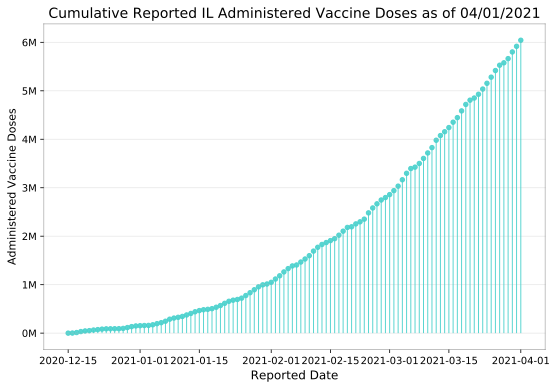

In [14]:
fig, ax = plt.subplots(figsize=(9,6), dpi= 100)
ax.vlines(x=vac.index, ymin=0, ymax=vac['AdministeredCount'], color='mediumturquoise', alpha=0.9, linewidth=1)
ax.scatter(x=vac.index, y=vac['AdministeredCount'], s=20, color='mediumturquoise', alpha=0.9)
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Cumulative Reported IL Administered Vaccine Doses as of {}/{}/{}'.format(month, day, year), size=14)
ax.set_xlabel('Reported Date',size=12)
ax.set_ylabel('Administered Vaccine Doses',size=11)
fig.savefig('IL_tab_charts_cumulative_vaccine.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Counties With The Highest Administered Vaccine Doses As Of The Most Recent Date

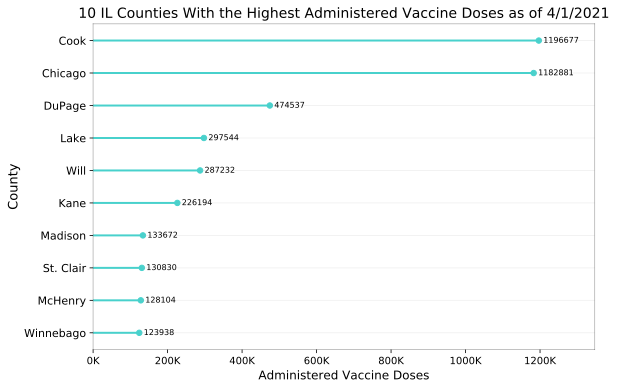

In [15]:
vac_county_url = "https://idph.illinois.gov/DPHPublicInformation/api/covidVaccine/getVaccineAdministrationCurrent"

with urllib.request.urlopen(vac_county_url) as url:
    data = json.loads(url.read().decode())
df = pd.json_normalize(data['VaccineAdministration'])
date = pd.json_normalize(data['lastUpdatedDate'])
year = str(date.year.values[0])
month = str(date.month.values[0])
day = str(date.day.values[0])
vac_county = pd.DataFrame(df.loc[df['CountyName']!='Illinois'])
vac_county.sort_values('AdministeredCount', inplace=True)
vac_county.reset_index(inplace=True)

top10 = vac_county.tail(10)
bottom10 = vac_county.head(10)

fig, ax = plt.subplots(figsize=(9,6), dpi= 100)
ax.hlines(y=top10.CountyName, xmin=0, xmax=top10['AdministeredCount'], color='mediumturquoise', linewidth=2)
ax.scatter(y=top10.CountyName, x=top10['AdministeredCount'], s=30, color='mediumturquoise')
plt.grid(axis='y', alpha=.2)
plt.yticks(fontsize=8.5)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
plt.yticks(fontsize=11)
plt.xlim([0, max(top10['AdministeredCount'])+150000])
ax.set_title('10 IL Counties With the Highest Administered Vaccine Doses as of {}/{}/{}'.format(month, day, year), size=14)
ax.set_xlabel('Administered Vaccine Doses',size=12)
ax.set_ylabel('County',size=13)
for x, y, tex in zip(top10.AdministeredCount, top10.CountyName, top10.AdministeredCount):
    t = plt.text(x+12000, y, round(tex, 0), horizontalalignment='left', 
                 verticalalignment='center', fontdict={'color':'black','size':8})
fig.savefig('IL_tab_charts_vaccine_by_county_top10.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Counties With The Lowest Administered Vaccine Doses As Of The Most Recent Date

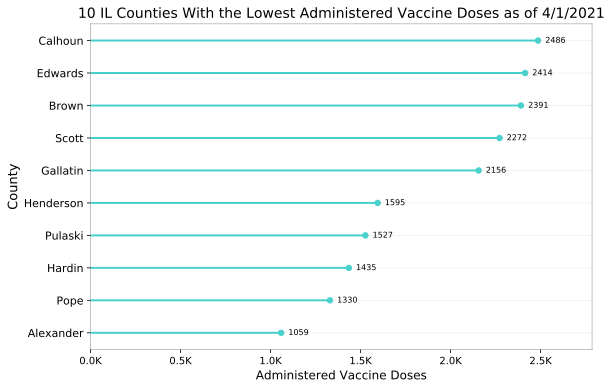

In [16]:
fig, ax = plt.subplots(figsize=(9,6), dpi= 100)
#ax.margins(x=0.09, y=0.02) 
ax.hlines(y=bottom10.CountyName, xmin=0, xmax=bottom10['AdministeredCount'], color='mediumturquoise', linewidth=2)
ax.scatter(y=bottom10.CountyName, x=bottom10['AdministeredCount'], s=30, color='mediumturquoise')
plt.grid(axis='y', alpha=.2)
plt.yticks(fontsize=8.5)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)
formatter = FuncFormatter(thousands)
ax.xaxis.set_major_formatter(formatter)
plt.yticks(fontsize=11)
plt.xlim([0, max(bottom10['AdministeredCount'])+300])
ax.set_title('10 IL Counties With the Lowest Administered Vaccine Doses as of {}/{}/{}'.format(month, day, year), size=14)
ax.set_xlabel('Administered Vaccine Doses',size=12)
ax.set_ylabel('County',size=13)
for x, y, tex in zip(bottom10.AdministeredCount, bottom10.CountyName, bottom10.AdministeredCount):
    t = plt.text(x+40, y, round(tex, 0), horizontalalignment='left', 
                 verticalalignment='center', fontdict={'color':'black','size':8})
fig.savefig('IL_tab_charts_vaccine_by_county_bottom10.svg', dpi=300, bbox_inches='tight')

## Google Mobility Data Visualization in Illinois 
* Data Source: [Google COVID-19 Community Mobility Reports](https://www.google.com/covid19/mobility/index.html?hl=en)
* API: Google BigQuery API Client with authentication setup required 

In [17]:
# The Google application credentials should already be set up
# (GOOGLE_APPLICATION_CREDENTIALS env var)

# Create Client object for query purpose
client = bigquery.Client()

sql_us="""
  SELECT
  country_region,
  sub_region_1,
  iso_3166_2_code,
  date,
  retail_and_recreation_percent_change_from_baseline as recreation,
  grocery_and_pharmacy_percent_change_from_baseline as grocery,
  parks_percent_change_from_baseline as park,
  transit_stations_percent_change_from_baseline as transit,
  workplaces_percent_change_from_baseline as workplace,
  residential_percent_change_from_baseline as residential  
  FROM `bigquery-public-data.covid19_google_mobility.mobility_report`
  WHERE 
    country_region_code = 'US' AND 
    sub_region_1 is not null AND
    iso_3166_2_code is not null
  order by sub_region_1, date
"""
us_query_job = client.query(sql_us)
rows = us_query_job.result()  # Waits for query to finish

cols = ['date', 'recreation', 'grocery', 'park', 'transit','workplace','residential']
lst = []
for row in rows:
    if row.iso_3166_2_code == 'US-IL':
        lst.append([row.date, 
                    row.recreation, 
                    row.grocery,
                    row.park,
                    row.transit,
                    row.workplace,
                    row.residential
                    ])
mobility_df = pd.DataFrame(lst, columns=cols)    

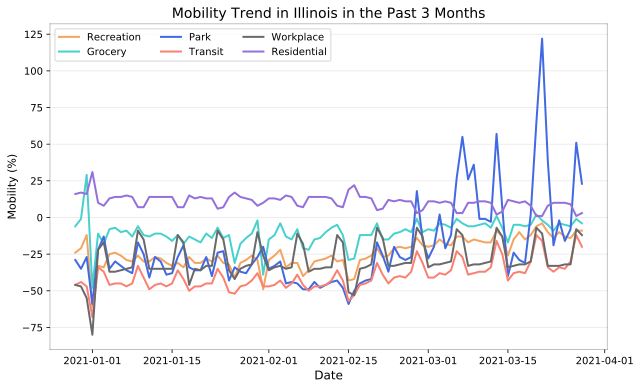

In [18]:
past_3m = mobility_df[-90:]
fig, ax = plt.subplots(figsize=(10,6), dpi= 100) 
plt.plot(past_3m.date, past_3m['recreation'].values, lw=2, color='sandybrown', label='Recreation') 
plt.plot(past_3m.date, past_3m['grocery'].values, lw=2, color='mediumturquoise', label='Grocery') 
plt.plot(past_3m.date, past_3m['park'].values, lw=2, color='royalblue', label='Park') 
plt.plot(past_3m.date, past_3m['transit'].values, lw=2, color='salmon', label='Transit') 
plt.plot(past_3m.date, past_3m['workplace'].values, lw=2, color='dimgray', label='Workplace') 
plt.plot(past_3m.date, past_3m['residential'].values, lw=2, color='mediumpurple', label='Residential') 
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
plt.legend(loc='upper left', ncol=3)
ax.set_title('Mobility Trend in Illinois in the Past 3 Months', size=14)
ax.set_xlabel('Date',size=12)
ax.set_ylabel('Mobility (%)',size=11)
fig.savefig('IL_tab_charts_IL_mobility.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

## Statistical Model Forecasts Cumulative COVID-19 Cases
* Data Source: [COVID-19 Data Repository by Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19)
* API: https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

In [19]:
def obs_pred_rsquare(obs, pred):
    
    obs = np.array(obs)
    pred = np.array(pred)
    
    # obs: an array of observations, whether transformed (log, sqrt, etc.) or not.
    # pred: an array of predictions, whether transformed (log, sqrt, etc.) or not.

    # Determines the prop of variability in a data set accounted for by a model
    # In other words, this determines the proportion of variation explained by
    # the 1:1 line in an observed-predicted plot.
    # Used in the following publications, among others:
        # 1. Locey, K. J., & White, E. P. (2013). How species richness and total abundance 
        #    constrain the distribution of abundance. Ecology letters, 16(9), 1177-1185.
        # 2. White, E. P., Thibault, K. M., & Xiao, X. (2012). Characterizing species 
        #    abundance distributions across taxa and ecosystems using a simple maximum 
        #    entropy model. Ecology, 93(8), 1772-1778.
       
    return 1 - sum((obs - pred) ** 2) / sum((obs - np.mean(obs)) ** 2)



########## Finding a best fit cumulative Gaussian curve via numerical optimization ######

def gaussian1(x, n, s, m):  
    
    # A function used in combination with scipy.optimize.curve_fit to find the best fit
    # cumulative Gaussian curve.
    
    # The following alternative can be used to find the best fit (non-cumulative) Gaussian curve:
        # return n**2 * (1/(s*((2*pi)**0.5))) * np.exp(-0.5 * ((x - m)/s)**2)
        
    return (n * 0.5 * (1 + sc.special.erf((x - m)/(s*2**0.5))))
    
def gaussian2(x, n, s, m, s1, m1):
    # A function used in combination with scipy.optimize.curve_fit to find the best fit
    # cumulative two-phase Gaussian curve. That is, a curve with two phases of 
    # Guassian like growth
    
    return (n * 0.5 * ((1 + sc.special.erf((x - m)/(s*2**0.5))) + (1 + sc.special.erf((x - m1)/(s1*2**0.5)))))
    
def gaussian3(x, n, s, m, s1, m1, s2, m2):  
    # A function used in combination with scipy.optimize.curve_fit to find the best fit
    # cumulative three-phase Gaussian curve. That is, a curve with three phases of 
    # Guassian like growth
    
    return (n * 0.5 * ((1 + sc.special.erf((x - m)/(s*2**0.5))) + (1 + sc.special.erf((x - m1)/(s1*2**0.5))) + (1 + sc.special.erf((x - m2)/(s2*2**0.5)))))

def gaussian4(x, n, s, m, s1, m1, s2, m2, s3, m3):  
    # A function used in combination with scipy.optimize.curve_fit to find the best fit
    # cumulative three-phase Gaussian curve. That is, a curve with three phases of 
    # Guassian like growth
    
    return (n * 0.5 * ((1 + sc.special.erf((x - m)/(s*2**0.5))) + (1 + sc.special.erf((x - m1)/(s1*2**0.5))) + (1 + sc.special.erf((x - m2)/(s2*2**0.5))) + (1 + sc.special.erf((x - m3)/(s3*2**0.5)))))



############# Finding a best fit logistic curve via numerical optimization ##############

def logistic1(x, a, b, c, d):
    # A function used in combination with scipy.optimize.curve_fit to find the best fit
    # logistic curve.
    
    return  ((a / (d + np.exp(-c * x + b))))
    
def logistic2(x, a, b, c, d,  a1, b1, c1, d1):
    # Same as logistic1, but allows for two periods of logistic growth
    
    return  ((a / (d + np.exp(-c * x + b)))   +   (a1 / (d1 + np.exp(-c1 * x + b1))))

def logistic3(x, e, a, b, c, d,  a1, b1, c1, d1,  a2, b2, c2, d2):
    # Same as logistic1, but allows for three periods of logistic growth
    return  ((a / (d + np.exp(-c * x + b)))   +   (a1 / (d1 + np.exp(-c1 * x + b1)))   +   (a2 / (d2 + np.exp(-c2 * x + b2)))) 

def logistic4(x, e, a, b, c, d,  a1, b1, c1, d1,  a2, b2, c2, d2,  a3, b3, c3, d3,):
    # Same as logistic1, but allows for three periods of logistic growth
    return  ((a / (d + np.exp(-c * x + b)))   +   (a1 / (d1 + np.exp(-c1 * x + b1)))   +   (a2 / (d2 + np.exp(-c2 * x + b2)))  +  (a3 / (d3 + np.exp(-c3 * x + b3)))) 




######## Find a best fit sine-logistic curve (phase wave) via numerical optimization ####

def phase_wave1(x,  a, b, c, d, f, g):
    # A function used in combination with scipy.optimize.curve_fit to find the best fit
    # sine-logistic curve. This curve captures the combined effect of logistic growth and
    # periodic fluctuations (sine curve).
    
    return  (a / (d + np.exp(-c * (x + g*np.sin(f*x)) + b)))
    
def phase_wave2(x,  a, b, c, d, f, g,   a1, b1, c1, d1, g1, f1):
    # Same as phase_wave1 but captures two phases of logistic growth, both characterized by
    # periodic fluctuations.
    
    return  (a / (d + np.exp(-c * (x + g*np.sin(f*x)) + b))   +   a1 / (d1 + np.exp(-c1 * (x + g1*np.sin(f1*x)) + b1)))
    
def phase_wave3(x, a, b, c, d, f, g,   a1, b1, c1, d1, g1, f1,   a2, b2, c2, d2, g2, f2):
    # Same as phase_wave1 but captures three phases of logistic growth, each characterized by
    # periodic fluctuations.
    
    return  (a / (d + np.exp(-c * (x + g*np.sin(f*x)) + b)) + a1 / (d1 + np.exp(-c1 * (x + g1*np.sin(f1*x)) + b1)) + a2 / (d2 + np.exp(-c2 * (x + g2*np.sin(f2*x)) + b2)))

def phase_wave4(x, a, b, c, d, f, g,   a1, b1, c1, d1, g1, f1,   a2, b2, c2, d2, g2, f2,   a3, b3, c3, d3, g3, f3):
    # Same as phase_wave1 but captures three phases of logistic growth, each characterized by
    # periodic fluctuations.
    
    return  (a / (d + np.exp(-c * (x + g*np.sin(f*x)) + b)) + a1 / (d1 + np.exp(-c1 * (x + g1*np.sin(f1*x)) + b1)) + a2 / (d2 + np.exp(-c2 * (x + g2*np.sin(f2*x)) + b2))  +  a3 / (d3 + np.exp(-c3 * (x + g3*np.sin(f3*x)) + b3)))
      

In [20]:
jh_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
il_data = jh_data.loc[jh_data.Province_State=='Illinois']
il_data1 = il_data.set_index('Admin2').T
il_data2 = il_data1.iloc[10:]

In [21]:
data_sum = pd.DataFrame(il_data2.sum(axis=1), columns=['cases'])
daily_data = data_sum.diff().iloc[1:]
update_date = str(data_sum.index[-1])

### Using 4-Phase Sine-Logistic Model and Data from Past 180 Days to Obtain Cumulative Cases Forecasts for Future 10 Days

180 observed values; 180 predicted values
Observed vs. Predicted r2: 0.9998977241749483
10 forecasted values


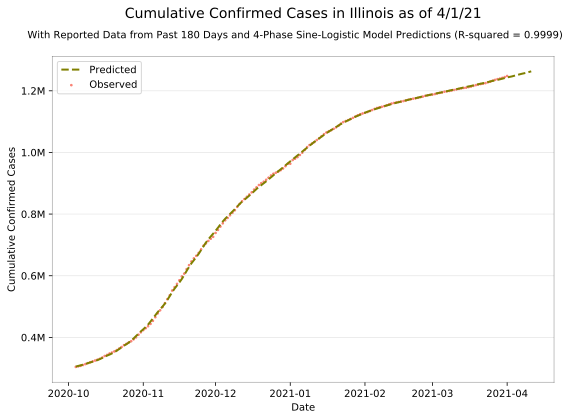

In [22]:
obs_y = data_sum.cases[-180:].to_list() # A list of observed values. Using range(1000) is not the best example for fitting a cumulative Guassian fxn.
obs_x = range(len(obs_y))

ForecastDays = 10 # The number of days ahead you want to forecast

# Get the optimized parameters (popt). See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
popt, pcov = curve_fit(phase_wave4, obs_x, obs_y, method='lm', maxfev=500000)

# Get predicted values
pred_y = phase_wave4(obs_x, *popt)

# Get the percent of variation in the observed explained by the predicted
# Note: the resulting coefficient of determination is for a line with slope of 1 and
# an intercept of 0. Hence, it is mathematically possible to obtain a negative value.
# Any negative value for the r2 variable should not be interpreted.
r2 = obs_pred_rsquare(obs_y, pred_y)
print(len(obs_y), 'observed values;', len(pred_y), 'predicted values')
print('Observed vs. Predicted r2:', r2)


# Get forecasted values
# 1. Extend x values by number of ForecastDays
forecasted_x = np.array(list(range(max(obs_x) + ForecastDays + 1)))

# 2. Get corresponding forecasted y values, i.e., extrapolations of fitted functions
forecasted_y = phase_wave4(forecasted_x, *popt)

print(len(forecasted_y) - len(pred_y), 'forecasted values')

start_date = data_sum.index[-180]
fig, ax = plt.subplots(figsize=(9,6), dpi= 100) 
plt.plot( pd.date_range(start=start_date, periods=len(forecasted_y), freq='D'), forecasted_y, marker='', color='olive', linewidth=2, linestyle='dashed', label="Predicted")
ax.scatter( pd.date_range(start=start_date, periods=len(obs_y), freq='D'), obs_y, color='salmon', s=3, label="Observed")

# show legend
plt.legend()
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
plt.legend(loc='upper left')
ax.set_title('Cumulative Confirmed Cases in Illinois as of {}'.format(update_date), size=14, y=1.1)
plt.suptitle('With Reported Data from Past 180 Days and 4-Phase Sine-Logistic Model Predictions (R-squared = {:.4f})'.format(r2),fontsize=10, y=0.94)
ax.set_xlabel('Date',size=10)
ax.set_ylabel('Cumulative Confirmed Cases',size=10)
fig.savefig('IL_tab_charts_cumulative_sine_logistic_last180days.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Using 4-Phase Sine-Logistic Model and Data from Past 360 Days to Obtain Cumulative Cases Forecasts for Future 30 Days

360 observed values; 360 predicted values
Observed vs. Predicted r2: 0.9999256427545165
30 forecasted values


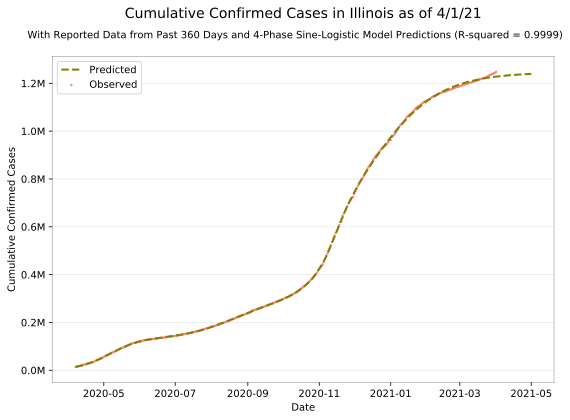

In [23]:
obs_y = data_sum.cases[-360:].to_list() # A list of observed values. Using range(1000) is not the best example for fitting a cumulative Guassian fxn.
obs_x = range(len(obs_y))

ForecastDays = 30 # The number of days ahead you want to forecast

# Get the optimized parameters (popt). See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
popt, pcov = curve_fit(phase_wave4, obs_x, obs_y, method='lm', maxfev=500000)

# Get predicted values
pred_y = phase_wave4(obs_x, *popt)

# Get the percent of variation in the observed explained by the predicted
# Note: the resulting coefficient of determination is for a line with slope of 1 and
# an intercept of 0. Hence, it is mathematically possible to obtain a negative value.
# Any negative value for the r2 variable should not be interpreted.
r2 = obs_pred_rsquare(obs_y, pred_y)
print(len(obs_y), 'observed values;', len(pred_y), 'predicted values')
print('Observed vs. Predicted r2:', r2)

start_date = data_sum.index[-360]
# Get forecasted values
# 1. Extend x values by number of ForecastDays
forecasted_x = np.array(list(range(max(obs_x) + ForecastDays + 1)))

# 2. Get corresponding forecasted y values, i.e., extrapolations of fitted functions
forecasted_y = phase_wave4(forecasted_x, *popt)

print(len(forecasted_y) - len(pred_y), 'forecasted values')

fig, ax = plt.subplots(figsize=(9,6), dpi= 100) 
plt.plot( pd.date_range(start=start_date, periods=len(forecasted_y), freq='D'), forecasted_y, marker='', color='olive', linewidth=2, linestyle='dashed',label="Predicted")
ax.scatter( pd.date_range(start=start_date, periods=len(obs_y), freq='D'), obs_y, color='salmon', s=2, label="Observed")

# show legend
plt.legend()
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Cumulative Confirmed Cases in Illinois as of {}'.format(update_date), size=14, y=1.1)
plt.suptitle('With Reported Data from Past 360 Days and 4-Phase Sine-Logistic Model Predictions (R-squared = {:.4f})'.format(r2),fontsize=10, y=0.94)
ax.set_xlabel('Date',size=10)
ax.set_ylabel('Cumulative Confirmed Cases',size=10)
fig.savefig('IL_tab_charts_cumulative_sine_logistic_last360.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Using 4-phase Logistic Model and Data from Past 180 Days to Obtain Cumulative Cases Forecasts for Future 10 Days

180 observed values; 180 predicted values
Observed vs. Predicted r2: 0.9999086647495523
10 forecasted values


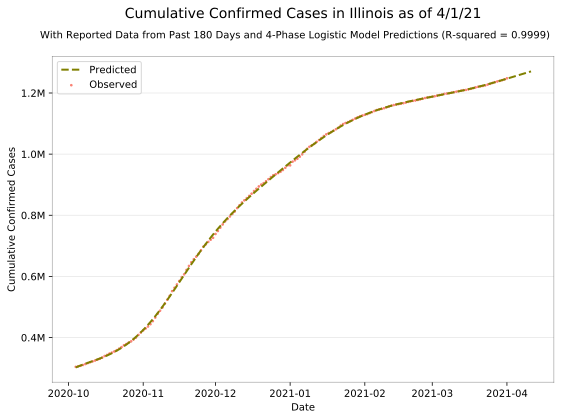

In [24]:
obs_y = data_sum.cases[-180:].to_list() # A list of observed values. Using range(1000) is not the best example for fitting a cumulative Guassian fxn.
obs_x = range(len(obs_y))

ForecastDays = 10 # The number of days ahead you want to forecast

# Get the optimized parameters (popt). See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
popt, pcov = curve_fit(logistic4, obs_x, obs_y, method='lm', maxfev=500000)

# Get predicted values
pred_y = logistic4(obs_x, *popt)

# Get the percent of variation in the observed explained by the predicted
# Note: the resulting coefficient of determination is for a line with slope of 1 and
# an intercept of 0. Hence, it is mathematically possible to obtain a negative value.
# Any negative value for the r2 variable should not be interpreted.
r2 = obs_pred_rsquare(obs_y, pred_y)
print(len(obs_y), 'observed values;', len(pred_y), 'predicted values')
print('Observed vs. Predicted r2:', r2)


# Get forecasted values
# 1. Extend x values by number of ForecastDays
forecasted_x = np.array(list(range(max(obs_x) + ForecastDays + 1)))

# 2. Get corresponding forecasted y values, i.e., extrapolations of fitted functions
forecasted_y = logistic4(forecasted_x, *popt)

print(len(forecasted_y) - len(pred_y), 'forecasted values')
start_date = data_sum.index[-180]
fig, ax = plt.subplots(figsize=(9,6), dpi= 100) 
plt.plot( pd.date_range(start=start_date, periods=len(forecasted_y), freq='D'), forecasted_y, marker='', color='olive', linestyle='dashed', linewidth=2, label="Predicted")
ax.scatter( pd.date_range(start=start_date, periods=len(obs_y), freq='D'), obs_y, color='salmon', s=3, label="Observed")
# show legend
plt.legend()
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Cumulative Confirmed Cases in Illinois as of {}'.format(update_date), size=14, y=1.1)
plt.suptitle('With Reported Data from Past 180 Days and 4-Phase Logistic Model Predictions (R-squared = {:.4f})'.format(r2),fontsize=10, y=0.94)
ax.set_xlabel('Date',size=10)
ax.set_ylabel('Cumulative Confirmed Cases',size=10)
fig.savefig('IL_tab_charts_cumulative_logistic_last180days.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Using 4-phase Logistic Model and Data from Past 360 Days to Obtain Cumulative Cases Forecasts for Future 30 Days 

360 observed values; 360 predicted values
Observed vs. Predicted r2: 0.9999251732692407
30 forecasted values


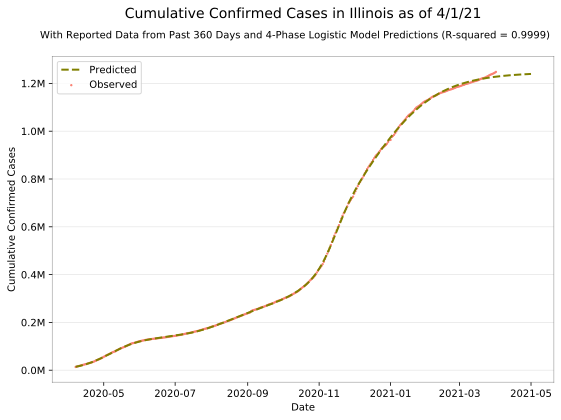

In [25]:
obs_y = data_sum.cases.to_list()[-360:] # A list of observed values. Using range(1000) is not the best example for fitting a cumulative Guassian fxn.
obs_x = range(len(obs_y))

ForecastDays = 30 # The number of days ahead you want to forecast

# Get the optimized parameters (popt). See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
popt, pcov = curve_fit(logistic4, obs_x, obs_y, method='lm', maxfev=500000)

# Get predicted values
pred_y = logistic4(obs_x, *popt)

# Get the percent of variation in the observed explained by the predicted
# Note: the resulting coefficient of determination is for a line with slope of 1 and
# an intercept of 0. Hence, it is mathematically possible to obtain a negative value.
# Any negative value for the r2 variable should not be interpreted.
r2 = obs_pred_rsquare(obs_y, pred_y)
print(len(obs_y), 'observed values;', len(pred_y), 'predicted values')
print('Observed vs. Predicted r2:', r2)


# Get forecasted values
# 1. Extend x values by number of ForecastDays
forecasted_x = np.array(list(range(max(obs_x) + ForecastDays + 1)))

# 2. Get corresponding forecasted y values, i.e., extrapolations of fitted functions
forecasted_y = logistic4(forecasted_x, *popt)

print(len(forecasted_y) - len(pred_y), 'forecasted values')
start_date = data_sum.index[-360]
fig, ax = plt.subplots(figsize=(9,6), dpi= 100) 
plt.plot( pd.date_range(start=start_date, periods=len(forecasted_y), freq='D'), forecasted_y, marker='', color='olive', linewidth=2,linestyle='dashed', label="Predicted")
ax.scatter( pd.date_range(start=start_date, periods=len(obs_y), freq='D'), obs_y, color='salmon', s=2, label="Observed")
# show legend
plt.legend()
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Cumulative Confirmed Cases in Illinois as of {}'.format(update_date), size=14, y=1.1)
plt.suptitle('With Reported Data from Past 360 Days and 4-Phase Logistic Model Predictions (R-squared = {:.4f})'.format(r2),fontsize=10, y=0.94)
ax.set_xlabel('Date',size=10)
ax.set_ylabel('Cumulative Confirmed Cases',size=10)
fig.savefig('IL_tab_charts_cumulative_logistic_last360.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)

### Using 4-Phase Logistic Model and Data from Past 360 Days to Obtain Daily New Cases Forecasts for Future 30 Days

360 observed values; 360 predicted values
Observed vs. Predicted r2: 0.8719522338762613
30 forecasted values


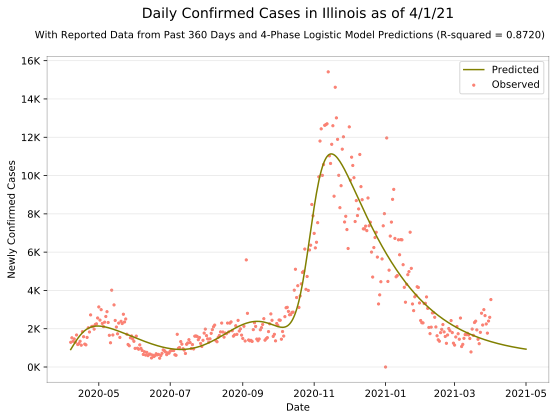

In [26]:
obs_y = daily_data.cases.to_list()[-360:] # A list of observed values. Using range(1000) is not the best example for fitting a cumulative Guassian fxn.
obs_x = range(len(obs_y))

ForecastDays = 30 # The number of days ahead you want to forecast

# Get the optimized parameters (popt). See: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
popt, pcov = curve_fit(logistic4, obs_x, obs_y, method='lm', maxfev=500000)

# Get predicted values
pred_y = logistic4(obs_x, *popt)

# Get the percent of variation in the observed explained by the predicted
# Note: the resulting coefficient of determination is for a line with slope of 1 and
# an intercept of 0. Hence, it is mathematically possible to obtain a negative value.
# Any negative value for the r2 variable should not be interpreted.
r2 = obs_pred_rsquare(obs_y, pred_y)
print(len(obs_y), 'observed values;', len(pred_y), 'predicted values')
print('Observed vs. Predicted r2:', r2)


# Get forecasted values
# 1. Extend x values by number of ForecastDays
forecasted_x = np.array(list(range(max(obs_x) + ForecastDays + 1)))

# 2. Get corresponding forecasted y values, i.e., extrapolations of fitted functions
forecasted_y = logistic4(forecasted_x, *popt)

print(len(forecasted_y) - len(pred_y), 'forecasted values')
start_date = data_sum.index[-360]
fig, ax = plt.subplots(figsize=(9,6), dpi= 100) 
plt.plot( pd.date_range(start=start_date, periods=len(forecasted_y), freq='D'), forecasted_y, marker='', color='olive', linewidth=1.5,label="Predicted")
ax.scatter( pd.date_range(start=start_date, periods=len(obs_y), freq='D'), obs_y, color='salmon', label="Observed", s=5)


# show legend
plt.legend()
plt.grid(axis='y', alpha=.3)
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatter = FuncFormatter(thousands)
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Daily Confirmed Cases in Illinois as of {}'.format(update_date), size=14, y=1.1)
plt.suptitle('With Reported Data from Past 360 Days and 4-Phase Logistic Model Predictions (R-squared = {:.4f})'.format(r2),fontsize=10, y=0.94)
ax.set_xlabel('Date',size=10)
ax.set_ylabel('Newly Confirmed Cases',size=10)
fig.savefig('IL_tab_charts_daily_logistic.svg', dpi=300, bbox_inches='tight')
#plt.close(fig)